# Compensation Buddy

## Environment Setup

In [6]:
!pip install --upgrade kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13


In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mount Google Drive
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/Projects/CompensationBuddy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Extraction

In [4]:
import kagglehub
import pandas as pd
import numpy as np

try:
    # Download Official DOL Source for FY2024 (LCA)
    path = kagglehub.dataset_download("zongaobian/h1b-lca-disclosure-data-2020-2024")
    print("Files in dataset directory:")
    for file in os.listdir(path):
      print(f"- {file}")
    keep_cols = [
        'CASE_STATUS', 'EMPLOYER_NAME', 'JOB_TITLE', 'SOC_TITLE',
        'WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY', 'WORKSITE_CITY',
        'WORKSITE_STATE', 'PW_WAGE_LEVEL'
    ]
    df = pd.read_csv(f"{path}/Combined_LCA_Disclosure_Data_FY2024.csv", usecols=keep_cols, low_memory=False) # handle mixed types in govt. data with low_memory=False
    print(f"Dataset loaded. Rows: {len(df):,}")
    print(f"Columns: {df.columns.tolist()[:10]}... (Total: {len(df.columns)})")
except Exception as e:
    print(f"Dataset load failed: {e}")

# Filter out certified software roles
df = df[df['CASE_STATUS'] == 'Certified']
tech_mask = df['JOB_TITLE'].str.contains('SOFTWARE|DATA|MACHINE LEARNING|AI', case=False, na=False)
df = df[tech_mask].copy()
print(f"Found {len(df):,}-certified Tech records.")

Using Colab cache for faster access to the 'h1b-lca-disclosure-data-2020-2024' dataset.
Files in dataset directory:
- Combined_LCA_Disclosure_Data_FY2022.csv
- Combined_LCA_Disclosure_Data_FY2024.csv
- Combined_LCA_Disclosure_Data_FY2023.csv
- Combined_LCA_Disclosure_Data_FY2020.csv
- Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv
- Combined_LCA_Disclosure_Data_FY2021.csv
Dataset loaded. Rows: 890,368
Columns: ['CASE_STATUS', 'JOB_TITLE', 'SOC_TITLE', 'EMPLOYER_NAME', 'WORKSITE_CITY', 'WORKSITE_STATE', 'WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY', 'PW_WAGE_LEVEL']... (Total: 9)
Found 261,468-certified Tech records.


## Data Cleaning

### Clean the data

- Step 1: Since WAGE_UNIT_OF_PAY can be hours, weeks, month, week or bi-weekly, we need to convert each into annual wages
- Step 2: Filter outliers. keep only range 50000-400000
- Step 3: Normalize the data  with log1p. we want bell-shaped, symmetric data

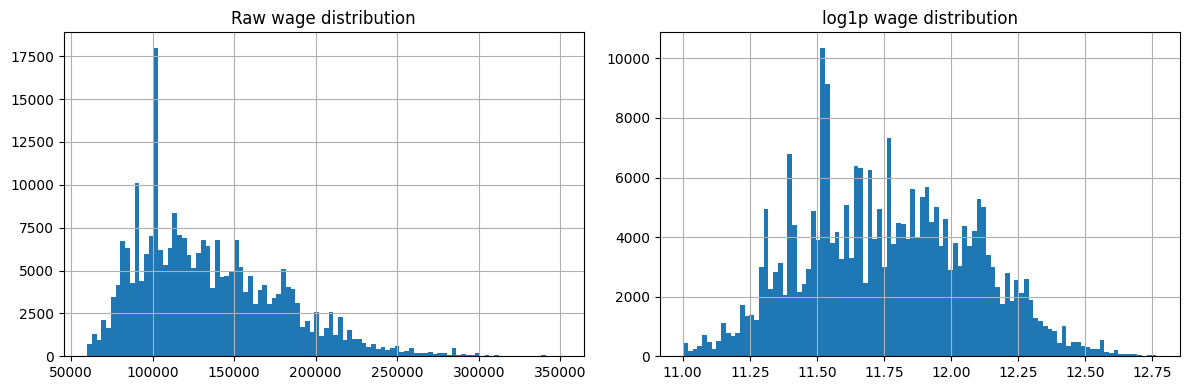

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: convert all wages to annual
multipliers = {
    'Year': 1,
    'Hour': 2080,# 40hrs * 52 weeks
    'Month': 12,
    'Week': 52,
    'Bi-Weekly': 26
}
df['annual_wage'] = df['WAGE_RATE_OF_PAY_FROM'] * df['WAGE_UNIT_OF_PAY'].map(multipliers)

# STEP 2: filter outliers
df = df[df['annual_wage'] >= 60000]
df = df[df['annual_wage'] <= 400000]

# STEP 3: normalize and plot the comparison.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['annual_wage'].hist(bins=100, ax=axes[0])
axes[0].set_title('Raw wage distribution')
# normalize with log1p
np.log1p(df['annual_wage']).hist(bins=100, ax=axes[1])
axes[1].set_title('log1p wage distribution')
plt.tight_layout()
plt.show()


### Categorize the data

In [27]:
print(df['WORKSITE_STATE'].nunique())
print(df['PW_WAGE_LEVEL'].value_counts())
print(df['JOB_TITLE'].nunique())
print(df['EMPLOYER_NAME'].nunique())

53
PW_WAGE_LEVEL
II     117690
III     46814
IV      34748
I       33388
Name: count, dtype: int64
20848
20748


#### Categorize the JOB_TITLE field

In [26]:
def categorize_title(title):
    t = title.lower()
    if any(k in t for k in ['machine learning', 'ml engineer', ' ai ', 'artificial intelligence', 'ai engineer']):
        return 'ML/AI'
    if 'data scientist' in t or 'data science' in t:
        return 'Data Science'
    if 'data engineer' in t:
        return 'Data Engineering'
    if any(k in t for k in ['data analyst', 'business analyst', 'data analytics', 'data']):
        return 'Analytics'
    if any(k in t for k in ['database', 'db admin']):
        return 'Database'
    if any(k in t for k in ['quality', ' qa ', 'test']):
        return 'QA/Testing'
    if any(k in t for k in ['manager', 'director', 'vice president', ' vp ', 'head of']):
        return 'Management'
    if any(k in t for k in ['devops', 'cloud', 'infrastructure', 'sre', 'site reliability']):
        return 'Infrastructure'
    if any(k in t for k in ['software', 'developer', 'swe', 'development']):
        return 'Software Engineering'
    return 'Other'

df['role_category'] = df['JOB_TITLE'].apply(categorize_title)
print(df['role_category'].value_counts())
print(f"\nUncategorized 'Other' examples:")
print(df[df['role_category'] == 'Other']['JOB_TITLE'].value_counts().head(20))

role_category
Software Engineering    178446
Analytics                22328
Data Engineering         14534
Data Science             12325
Management               11762
QA/Testing                9891
ML/AI                     4575
Other                     4469
Infrastructure            1606
Name: count, dtype: int64

Uncategorized 'Other' examples:
JOB_TITLE
Airline Pilot                                    186
Physician in a Post Graduate Training Program    164
Supply Chain Analyst                             129
Regulatory Affairs Specialist                     93
Captain                                           65
Domain Consultant L3                              49
Senior Regulatory Affairs Specialist              48
Supply Chain Engineer                             48
Regulatory Affairs Associate                      46
Domain Consultant L2                              39
graduate physician trainee                        35
Domain Architect                                  30
Do

#### Categorize the 'EMPLOYER_NAME' field

seperate into two feature
  - FAANG/top company (binary flag)
  - employer type (Big Tech / Consulting / Finance / Retail / Other)

In [36]:
# define top tier companies
top_tier = {
    'google', 'microsoft', 'apple', 'meta', 'amazon',
    'netflix', 'nvidia', 'salesforce', 'adobe', 'intel'
}
def is_top_tier(name):
    n = name.lower()
    return int(any(t in n for t in top_tier))

# put companies into types
def get_industry(name):
    n = name.lower()
    if any(k in n for k in ['google', 'microsoft', 'apple', 'meta', 'amazon', 'netflix', 'nvidia', 'salesforce', 'adobe', 'intel']):
        return 'Big Tech'
    if any(k in n for k in ['cognizant', 'tata', 'infosys', 'wipro', 'mphasis', 'compunnel', 'hcl', 'accenture']):
        return 'Consulting'
    if any(k in n for k in ['jpmorgan', 'fidelity', 'ernst', 'goldman', 'morgan stanley', 'wells fargo', 'bank of america', 'deloitte']):
        return 'Finance'
    if any(k in n for k in ['optum', 'unitedhealth', 'cvs', 'mayo', 'elevance']):
        return 'Healthcare'
    return 'Other'

df['is_top_tier'] = df['EMPLOYER_NAME'].apply(is_top_tier)
df['industry'] = df['EMPLOYER_NAME'].apply(get_industry)

print(df['is_top_tier'].value_counts())
print(df['industry'].value_counts())

is_top_tier
0    205526
1     54410
Name: count, dtype: int64
industry
Other         183250
Big Tech       54410
Finance        11375
Consulting     10023
Healthcare       878
Name: count, dtype: int64


#### Infer new feature 'seniority'

In [38]:
def get_seniority(title):
    t = title.lower()
    if any(k in t for k in ['vice president', ' vp ', 'director', 'head of']):
        return 'Leadership'

    if any(k in t for k in ['manager']):
        return 'Manager'

    if any(k in t for k in ['principal', ' iv', 'architect']):
        return 'Principal'

    if any(k in t for k in ['staff']):
        return 'Staff'

    if any(k in t for k in ['senior', 'sr.', 'sr ', ' iii']):
        return 'Senior'

    if any(k in t for k in [' ii', 'mid ', 'intermediate']):
        return 'Mid'

    if any(k in t for k in ['junior', 'jr', 'associate', ' i ', 'entry']):
        return 'Entry'

    # Plain "Software Engineer" with no level indicator → Mid
    return 'Mid'

df['seniority'] = df['JOB_TITLE'].apply(get_seniority)
print(df['seniority'].value_counts())

seniority
Mid           180474
Senior         45198
Manager        11949
Principal       8920
Staff           6230
Leadership      4968
Entry           2197
Name: count, dtype: int64


#### Categorize WORKSITE_CITY

In [40]:
def get_metro_tier(city):
    c = str(city).lower().strip()

    tier1 = [
        'san francisco', 'san jose', 'sunnyvale', 'mountain view',
        'menlo park', 'palo alto', 'santa clara','seattle', 'new york', 'manhattan']

    tier2 = [
        'bellevue', 'redmond','austin','boston', 'cambridge','atlanta',
        'los angeles', 'santa monica','chicago', 'denver', 'boulder',
    ]

    if any(k in c for k in tier1):
        return 'Tier1'
    if any(k in c for k in tier2):
        return 'Tier2'
    return 'Tier3'

df['metro_tier'] = df['WORKSITE_CITY'].apply(get_metro_tier)
print(df['metro_tier'].value_counts())

metro_tier
Tier3    168581
Tier1     58579
Tier2     32776
Name: count, dtype: int64


### Data Preprocessing

- STEP 1: Drop unused columns
- STEP 2: One-Hot Encode categorical columns
- STEP 3: Spit into X (features) and Y (annual_wage)

In [43]:
import numpy as np

# Step 1: Drop unused columns
cols_to_keep = ['role_category', 'seniority', 'WORKSITE_STATE',
                'PW_WAGE_LEVEL', 'industry', 'metro_tier',
                'is_top_tier', 'annual_wage']
df_model = df[cols_to_keep].copy()

# Step 2: One-Hot Encode categorical columns
df_model = pd.get_dummies(df_model, columns=["role_category", "seniority",'WORKSITE_STATE',
                'PW_WAGE_LEVEL', 'industry', 'metro_tier' ])

# Step 3: Spit into X (features) and Y (annual_wage)
Y = df_model['annual_wage'].values.reshape(-1, 1)
X = df_model.drop(columns=['annual_wage']).values

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
np.savez('tech_salary_dataset.npz', X=X.astype(np.float32), Y=Y.astype(np.float32))

X shape: (259936, 82)
Y shape: (259936, 1)
